In [1]:
import os
while os.path.basename(os.getcwd()) != 'CSDGAN':
    os.chdir('..')

import configs.wine as cfg
from utils.utils import *
from utils.data_loading import load_processed_dataset
import os
from CSDGAN.classes.tabular.TabularCGAN import TabularCGAN
from CSDGAN.classes.tabular.TabularDataset import TabularDataset
from torch.utils import data
import pickle as pkl
import random
%matplotlib inline

/home/aj/miniconda3/lib/python3.7/site-packages/dotenv.py:18: UserWarning: can't read /home/aj/PycharmProjects/CSDGAN/CSDGAN/utils/.env - it doesn't exist.
  warnings.warn("can't read %s - it doesn't exist." % dotenv_path)


### Set random seem for reproducibility

In [2]:
print("Random Seed: ", cfg.MANUAL_SEED)
random.seed(cfg.MANUAL_SEED)
torch.manual_seed(cfg.MANUAL_SEED)

Random Seed:  999


### Inspect config file
I have also implemented a config/wine.py file for all relevant user inputs for training the model. I recommend checking out this file and playing around with the inputs in order to experiment! I'm curious what results you may find. I will print out the current config setup below so that you have a good idea of the out-of-the-box parameters:

In [3]:
print("Experiment Name:", cfg.EXPERIMENT_NAME)  #  Where output files will be saved
print("Manual Seed:", cfg.MANUAL_SEED)  # This is above

print("\nEvaluation Parameters:")
print("Number of data set pass-throughs per epoch:", cfg.CADENCE)
print("Continuous Features:", cfg.CONT_INPUTS)
print("Integer Features:", cfg.INT_INPUTS)
print("Dependent Variable:", cfg.DEP_VAR)
print("Evaluation Parameter Grid:", cfg.EVAL_PARAM_GRID)
print("Number of cross-validation folds for evaluation:", cfg.EVAL_FOLDS)
print("Generated data set sizes to test for during evaluation:", cfg.TEST_RANGES)

print("\nTraining Parameters:")  # Whether to shuffle the data for training, and number of cpu workers for concurrency
print("Test Set Size:", cfg.TEST_SIZE)  # Number of examples in the test set
print("Total Number of Epochs:", cfg.NUM_EPOCHS)
print("Printing Frequency:", cfg.PRINT_FREQ)  # How often to print results to the console (in epochs)
print("Evaluation Frequency:", cfg.EVAL_FREQ)  # How often to train the evaluator on generated data (in epochs)

for key, value in cfg.TRAINING_PARAMS.items():
    print(key + ": " + str(value))

print("\nCGAN Class Initialization Parameters:")  # See the config file for more detail behind what these choices represent
for key, value in cfg.CGAN_INIT_PARAMS.items():
    print(key + ": " + str(value))

Experiment Name: Wine_Notebook_Example
Manual Seed: 999

Evaluation Parameters:
Number of data set pass-throughs per epoch: 1
Continuous Features: ['alcohol', 'malic_acid', 'ash', 'alkalinity', 'magnesium', 'phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'dilution', 'proline']
Integer Features: ['magnesium', 'proline']
Dependent Variable: class
Evaluation Parameter Grid: {'tol': [1e-05], 'C': [0.5], 'l1_ratio': [0]}
Number of cross-validation folds for evaluation: 5
Generated data set sizes to test for during evaluation: [90, 180, 360, 720, 1440]

Training Parameters:
Test Set Size: 88
Total Number of Epochs: 2000
Printing Frequency: 250
Evaluation Frequency: 250
batch_size: 1000
shuffle: False
num_workers: 0

CGAN Class Initialization Parameters:
nc: 3
nz: 64
sched_netG: 1
netG_H: 32
netD_H: 32
netG_lr: 0.0002
netD_lr: 0.0002
netG_beta1: 0.5
netD_beta1: 0.5
netG_beta2: 0.999
netD_beta2: 0.999
netG_wd: 0
netD_wd: 0
label_noise: 0.0
label_no

Feel free to play around with some of these!

### Directory for outputs

In [4]:
exp_path = os.path.join("experiments", cfg.EXPERIMENT_NAME)
print("Files for this experiment will end up here:", exp_path)

Files for this experiment will end up here: experiments/Wine_Notebook_Example


### Import and briefly inspect data

In [5]:
wine = load_processed_dataset('wine')
wine.head()

,class,alcohol,malic_acid,ash,alkalinity,magnesium,phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,dilution,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### Automatically determine these parameters and complete preprocessing

In [6]:
device = torch.device('cpu')  # torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu") # could run into memory issues
out_dim = wine.shape[1]
labels_list = list(wine[cfg.DEP_VAR].unique())

print("Device:", device)
print("Dimensions of a single row:", out_dim)
print("List of labels:", labels_list)

Device: cpu
Dimensions of a single row: 14
List of labels: [1, 2, 3]


### Define and instantiate data set and generator
I'm using Pytorch's built-in datasets and generator classes. The init method of this class takes care of the dirty work of organizing the data set by its continuous and categorical features, through label encoding, one hot encoding, splitting the data into train/test, and transforming the original DataFrame into tensors ready for training. I encourage you to check out the source code (or v1 of the notebook report) to get a better understanding as to what it is doing. 

In [7]:
dataset = TabularDataset(df=wine,
                         dep_var=cfg.DEP_VAR,
                         cont_inputs=cfg.CONT_INPUTS,
                         int_inputs=cfg.INT_INPUTS,
                         test_size=cfg.TEST_SIZE,
                         seed=cfg.MANUAL_SEED)
dataset.to_dev(device)
data_gen = data.DataLoader(dataset, **cfg.TRAINING_PARAMS)
eval_stratify = list(dataset.y_train.mean(0).detach().cpu().numpy())

print("Size of training data set:", dataset.x_train.shape[0])
print("Size of testing data set:", dataset.x_test.shape[0])
print("Label stratifications applied to evaluator model:", eval_stratify)

Size of training data set: 90
Size of testing data set: 88
Label stratifications applied to evaluator model: [0.33333334, 0.4, 0.26666668]


/home/aj/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/aj/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


### Instantiate the CGAN Class

In [8]:
CGAN = TabularCGAN(data_gen=data_gen,
                   device=device,
                   path=exp_path,
                   seed=cfg.MANUAL_SEED,
                   eval_param_grid=cfg.EVAL_PARAM_GRID,
                   eval_folds=cfg.EVAL_FOLDS,
                   test_ranges=cfg.TEST_RANGES,
                   eval_stratify=eval_stratify,
                   **cfg.CGAN_INIT_PARAMS)

### Visualize Network Architecture
I find it very helpful to draw out the architecture of our networks so I can better understand how I might be able to debug/improve it. Let's take a look!

Generator Architecture


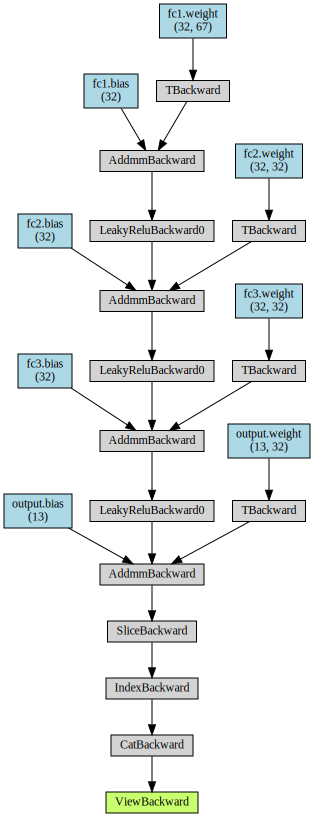

In [9]:
print("Generator Architecture")
viz = CGAN.draw_architecture(net=CGAN.netG, show=False, save=exp_path)
viz

Discriminator Architecture


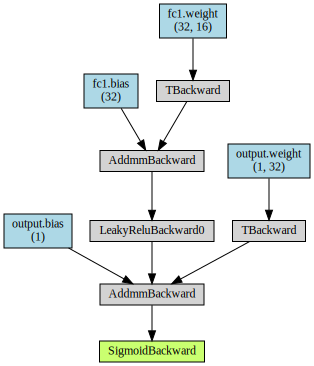

In [10]:
print("Discriminator Architecture")
viz = CGAN.draw_architecture(net=CGAN.netD, show=False, save=exp_path)
viz

### Evaluate performance on real data
Before we train our CGAN, let's train an evaluation model (logistic regression in this case) on the training data in order to come up with a benchmark accuracy that we will try to beat with our generator and evaluator combination.

In [11]:
score_real = train_test_logistic_reg(x_train=CGAN.data_gen.dataset.x_train.cpu().detach().numpy(),
                                     y_train=CGAN.data_gen.dataset.y_train.cpu().detach().numpy(),
                                     x_test=CGAN.data_gen.dataset.x_test.cpu().detach().numpy(),
                                     y_test=CGAN.data_gen.dataset.y_test.cpu().detach().numpy(),
                                     param_grid=cfg.EVAL_PARAM_GRID,
                                     cv=cfg.EVAL_FOLDS,
                                     random_state=cfg.MANUAL_SEED,
                                     labels_list=labels_list,
                                     verbose=True)

Best Accuracy: 97.73%
Best Parameters: {'C': 0.5, 'l1_ratio': 0, 'tol': 1e-05}
              precision    recall  f1-score   support

           1       0.97      1.00      0.98        29
           2       0.97      0.97      0.97        35
           3       1.00      0.96      0.98        24

    accuracy                           0.98        88
   macro avg       0.98      0.98      0.98        88
weighted avg       0.98      0.98      0.98        88

[[29  0  0]
 [ 1 34  0]
 [ 0  1 23]]


## Training the GAN
I've condensed the entire training code into a single line. If you are interested, feel free to check out the source code, but the training regimen is extremely similar to the one implemented for the prior data sets.

In [12]:
CGAN.train_gan(num_epochs=cfg.NUM_EPOCHS, cadence=cfg.CADENCE, print_freq=cfg.PRINT_FREQ, eval_freq=cfg.EVAL_FREQ)

Beginning training
Time: 2s
[250/2000]	Loss_D: 1.3582	Loss_G: 0.7104	D(x): 0.5079	D(G(z)): 0.4936 / 0.4915
Epoch: 250	Evaluator Score: 0.3636
Time: 2s
[500/2000]	Loss_D: 1.3459	Loss_G: 0.7134	D(x): 0.5123	D(G(z)): 0.4915 / 0.4902
Epoch: 500	Evaluator Score: 0.7159
Time: 1s
[750/2000]	Loss_D: 1.3117	Loss_G: 0.7359	D(x): 0.5259	D(G(z)): 0.4867 / 0.4801
Epoch: 750	Evaluator Score: 0.8523
Time: 1s
[1000/2000]	Loss_D: 1.3000	Loss_G: 0.7441	D(x): 0.5305	D(G(z)): 0.4836 / 0.4776
Epoch: 1000	Evaluator Score: 0.8977
Time: 1s
[1250/2000]	Loss_D: 1.3261	Loss_G: 0.7457	D(x): 0.5173	D(G(z)): 0.4841 / 0.4771
Epoch: 1250	Evaluator Score: 0.9886
Time: 2s
[1500/2000]	Loss_D: 1.3449	Loss_G: 0.7122	D(x): 0.5093	D(G(z)): 0.4867 / 0.4923
Epoch: 1500	Evaluator Score: 0.9886
Time: 1s
[1750/2000]	Loss_D: 1.3631	Loss_G: 0.7059	D(x): 0.5062	D(G(z)): 0.4930 / 0.4948
Epoch: 1750	Evaluator Score: 0.9773
Time: 2s
[2000/2000]	Loss_D: 1.3711	Loss_G: 0.6886	D(x): 0.5044	D(G(z)): 0.4961 / 0.5025
Epoch: 2000	Evaluator S

In [13]:
print("Highest score achieved: {0: .2%}".format(np.max(CGAN.stored_acc)))

Highest score achieved:  98.86%


###### Results
Wow! It looks like we succeeded in training a model entirely on fake data that could outperform a model trained on the actual data. This supports the idea that the GAN has achieved a good understanding of the underlying data distributions. We will go into detail and visualize different aspects of the model training in order to get a better understanding of what actually took place.

### Plot evaluation over time
First, let's look at how our estimate of model performance evolved as the model trained 10,000 epochs. Note, the red dashed line on the plot represents the performance of the model trained on real data from earlier.

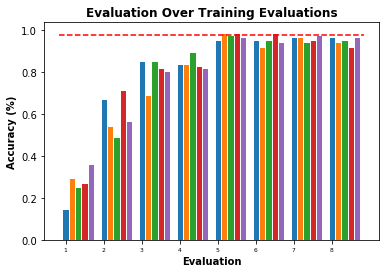

<Figure size 432x288 with 0 Axes>

In [14]:
CGAN.plot_progress(benchmark_acc=score_real, show=True, save=exp_path)

It appears that our model started off in a pretty terrible state (as expected through random initializations of weights), but as training persisted it's performance increased to the point where it was semi-consistently beating our benchmark accuracy. Let's load in our best-performing generator, and fit another model to evaluate its performance, mainly as a sanity check that everything is working correctly and to double check that we didn't just get lucky earlier with our high accuracy.

In [15]:
CGAN.load_netG(best=True)
new_acc = CGAN.test_model(stratify=CGAN.eval_stratify)
print("New test accuracy: {0: .2%}".format(np.max(new_acc)))

New test accuracy:  97.73%


### Visualizing model and training diagnostics
Next, let's take a look at some of the training diagnostic plots similar to what we did for the other data sets. I'll leave the interpretation up to you at this point!

/home/aj/PycharmProjects/CSDGAN/CSDGAN/classes/CGANUtils.py:108: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


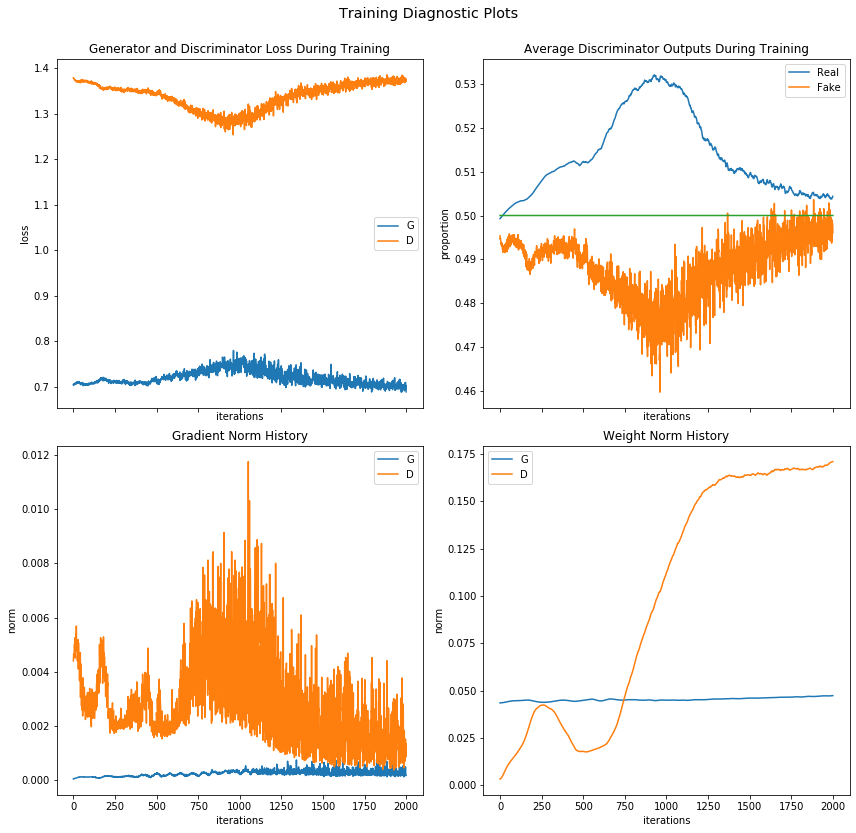

In [16]:
CGAN.plot_training_plots(show=True, save=exp_path)

/home/aj/PycharmProjects/CSDGAN/CSDGAN/classes/NetUtils.py:188: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


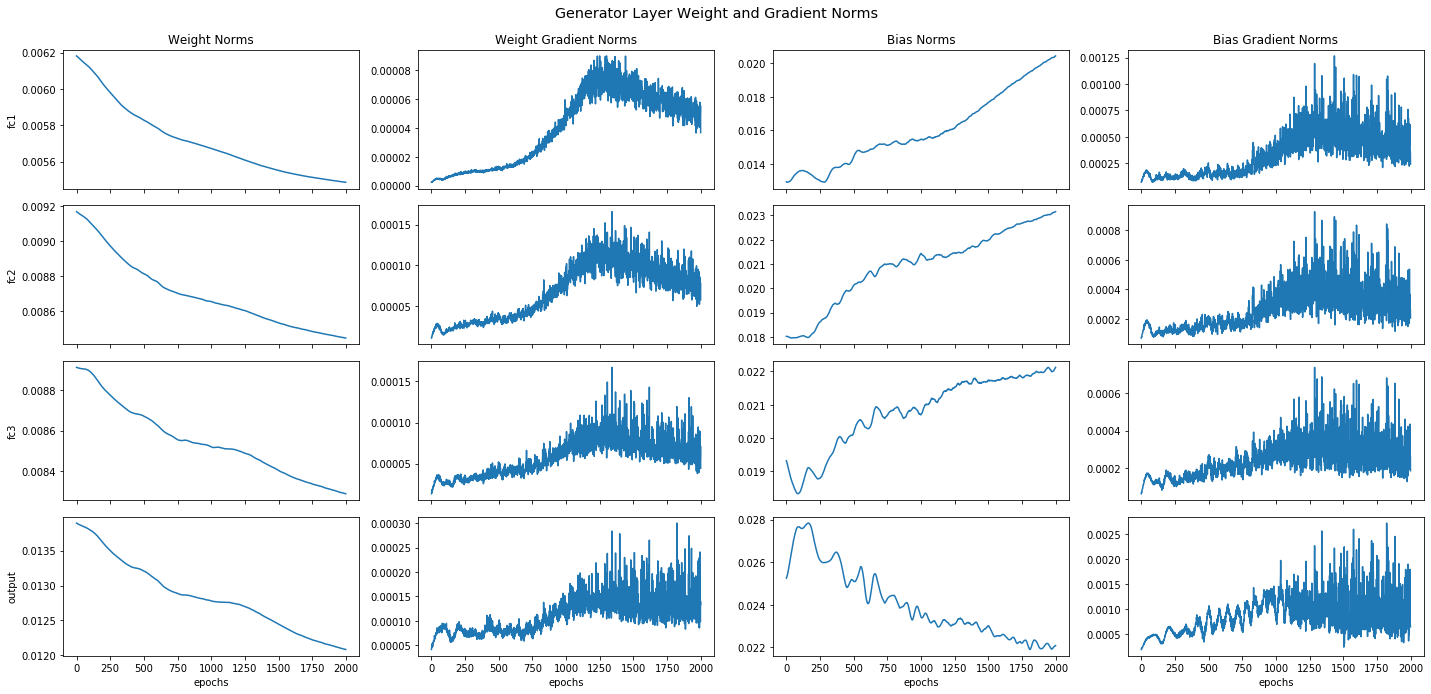

In [17]:
CGAN.netG.plot_layer_scatters(show=True, save=exp_path)

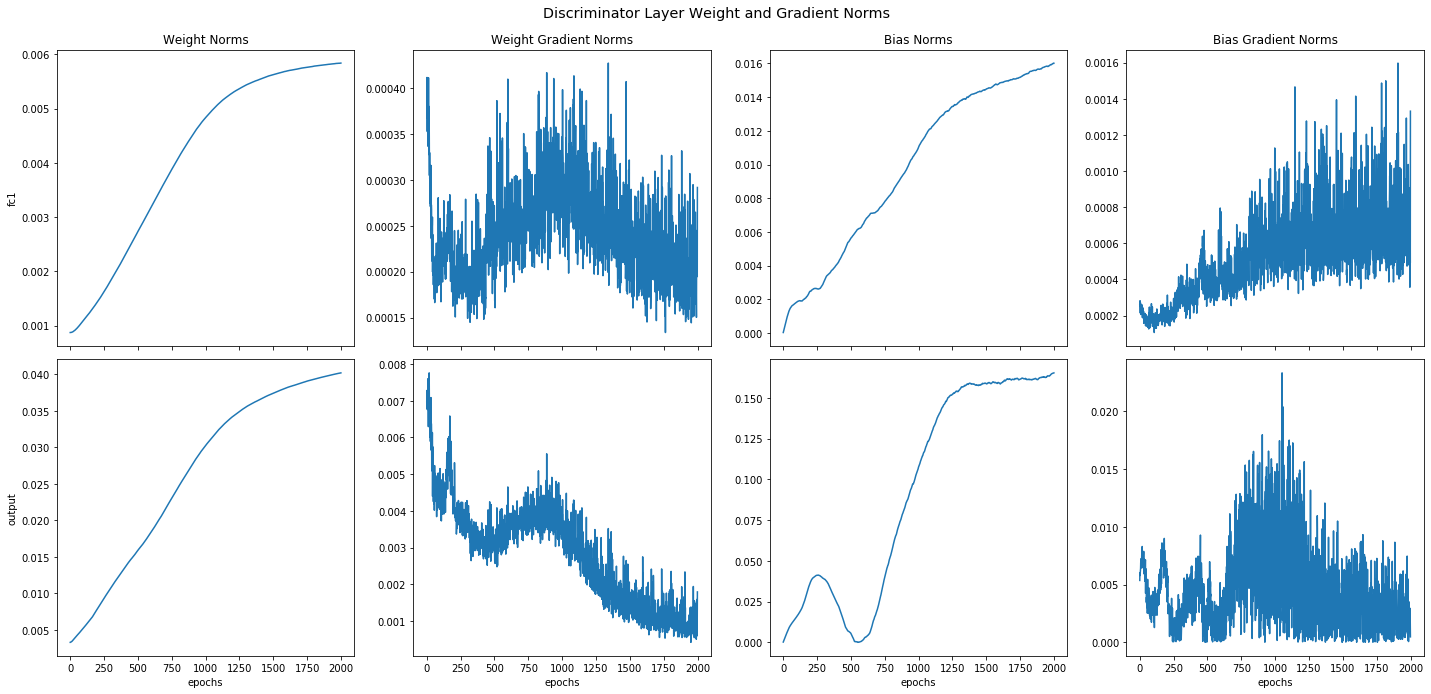

In [18]:
CGAN.netD.plot_layer_scatters(show=True, save=exp_path)

/home/aj/PycharmProjects/CSDGAN/CSDGAN/classes/NetUtils.py:237: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


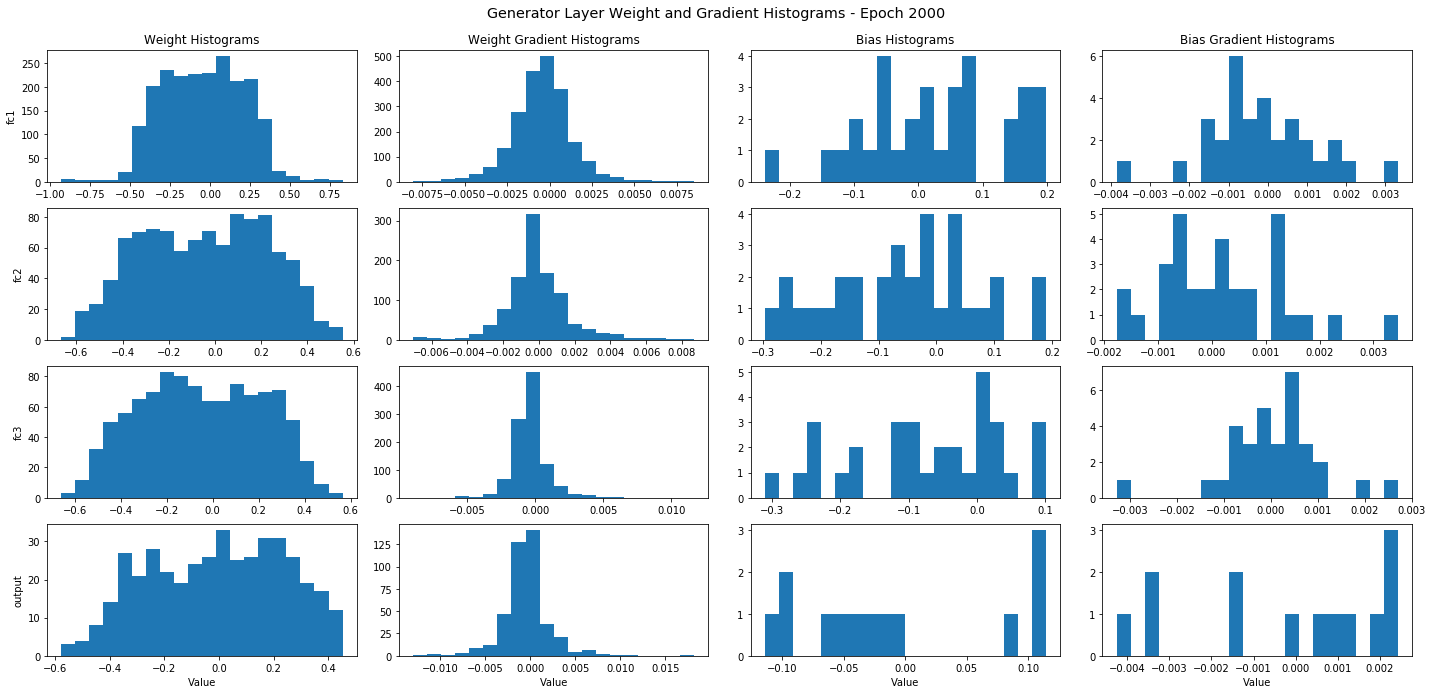

In [19]:
CGAN.netG.plot_layer_hists(show=True, save=exp_path)

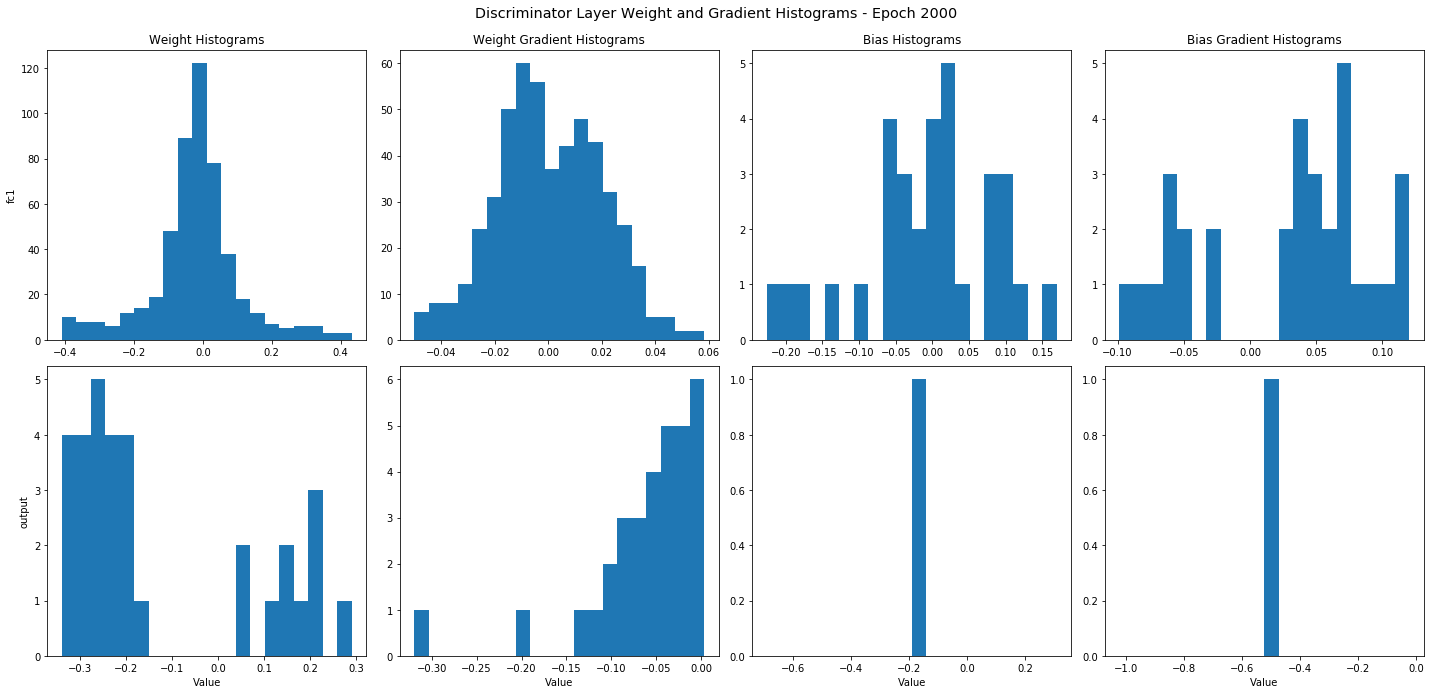

In [20]:
CGAN.netD.plot_layer_hists(show=True, save=exp_path)

### Visualizing data distributions and comparing real vs. fake data
We can also apply various methods to visualize and better understand the results of our newly trained generator. Let's generate a sample DataFrame of data and compare distributions of specific combinations of features.

In [21]:
genned_df = CGAN.gen_data(size=cfg.TEST_RANGES[3], stratify=eval_stratify)
genned_df.sample(5)

,class,alcohol,malic_acid,ash,alkalinity,magnesium,phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,dilution,proline
128,1,14.323664,2.535690,2.538225,16.891161,104,2.504934,3.016005,0.288378,1.731108,6.095361,1.093915,3.346422,1240
365,2,13.241448,2.572745,2.082519,22.638922,94,1.063674,1.815636,0.282011,0.779734,3.845157,0.835603,1.307057,13
353,2,12.707962,2.513416,2.040560,21.151722,91,1.818842,1.674497,0.384552,1.572555,6.158244,1.051699,2.807393,333
556,3,13.287269,2.085593,2.320439,19.030964,102,2.095726,1.651192,0.409977,0.866867,6.772521,0.768234,2.244737,976
61,1,13.693203,3.351739,2.224658,16.935535,110,3.340652,3.630944,0.086750,2.116856,6.307630,1.023749,3.119497,1178


In [22]:
wine.sample(5)

,class,alcohol,malic_acid,ash,alkalinity,magnesium,phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,dilution,proline
34,1,13.51,1.80,2.65,19.0,110,2.35,2.53,0.29,1.54,4.20,1.10,2.87,1095
112,2,11.76,2.68,2.92,20.0,103,1.75,2.03,0.60,1.05,3.80,1.23,2.50,607
163,3,12.96,3.45,2.35,18.5,106,1.39,0.70,0.40,0.94,5.28,0.68,1.75,675
60,2,12.33,1.10,2.28,16.0,101,2.05,1.09,0.63,0.41,3.27,1.25,1.67,680
86,2,12.16,1.61,2.31,22.8,90,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495


In [23]:
genned_df.describe()

,class,alcohol,malic_acid,ash,alkalinity,magnesium,phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,dilution,proline
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,1.933333,12.964143,2.316422,2.353838,19.159665,98.644444,2.233816,1.969776,0.378188,1.518010,5.174045,0.966093,2.615706,780.836111
std,0.772259,0.826151,0.943943,0.218324,3.128822,9.674751,0.670696,1.110992,0.120938,0.459893,2.433240,0.267031,0.778763,365.300560
min,1.000000,10.644904,-0.510288,1.588816,8.725471,70.000000,0.548303,-0.507280,-0.111467,0.215459,-2.796372,-0.139204,-0.023008,-74.000000
25%,1.000000,12.408458,1.658220,2.216702,17.002406,92.000000,1.743337,1.177028,0.297950,1.177726,3.635867,0.803423,2.119157,510.000000
50%,2.000000,13.005723,2.293655,2.368181,19.343804,98.000000,2.144879,1.819243,0.384297,1.496361,5.315869,1.009861,2.663319,701.500000
75%,3.000000,13.566440,2.946938,2.499035,21.290428,105.000000,2.739239,2.715369,0.462871,1.830459,6.814611,1.151900,3.128780,1054.250000
max,3.000000,14.913021,5.410731,3.097193,27.221468,130.000000,4.536150,5.636667,0.754996,2.894884,12.547820,1.806491,5.643516,1902.000000


In [24]:
wine.describe()

,class,alcohol,malic_acid,ash,alkalinity,magnesium,phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,dilution,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


#### Scatter Matrices

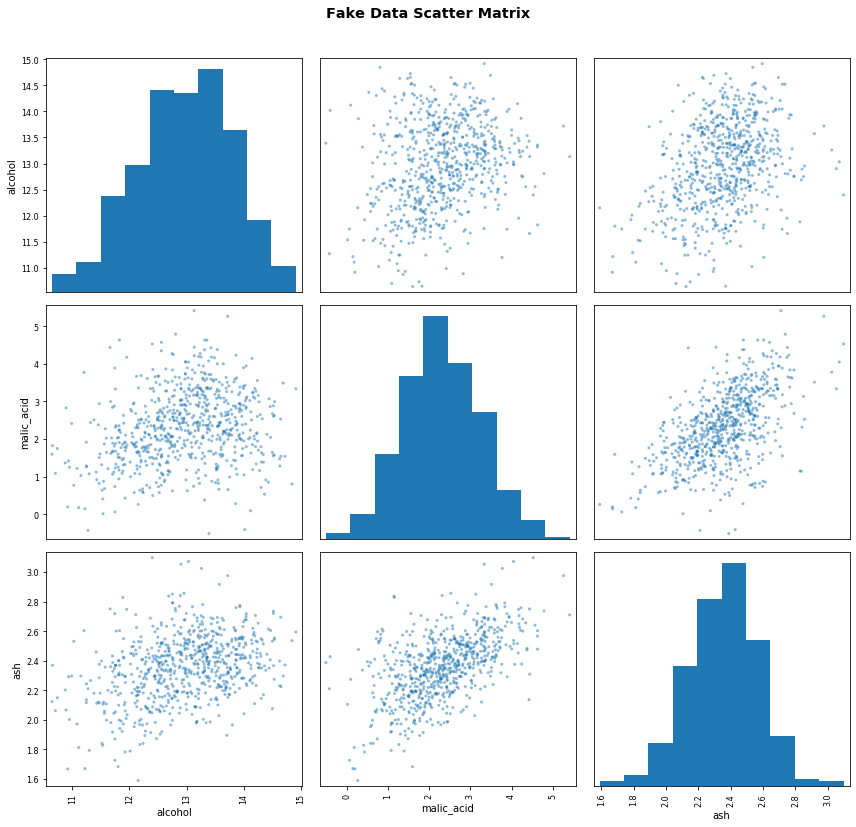

<Figure size 432x288 with 0 Axes>

In [25]:
plot_scatter_matrix(df=genned_df, cont_inputs=cfg.CONT_INPUTS[0:3], title="Fake Data", scaler=None, show=True, save=exp_path)

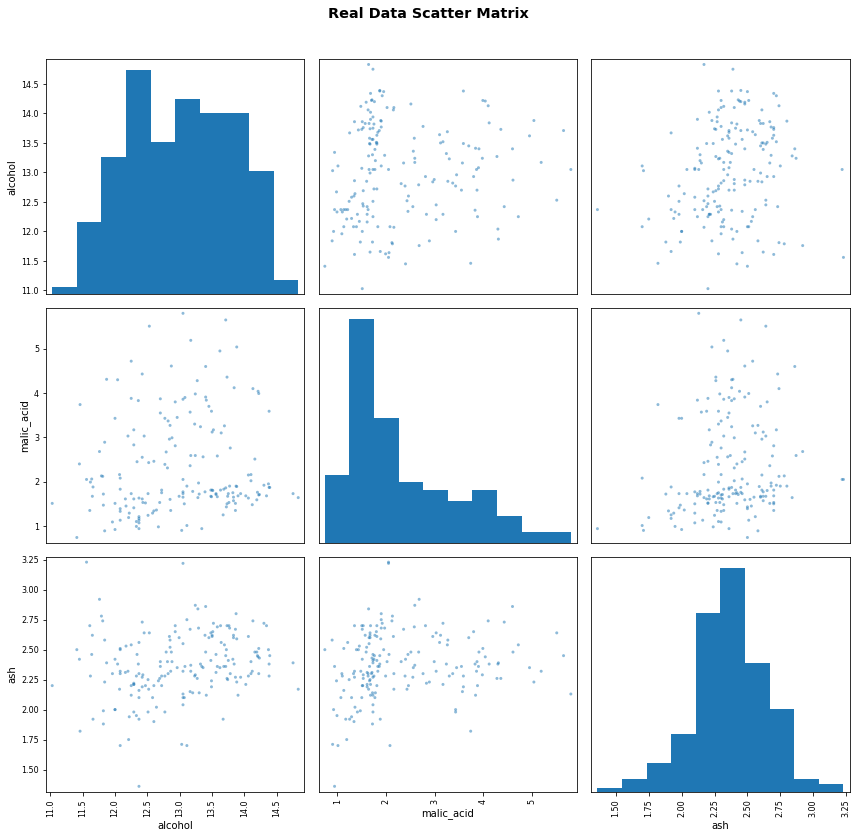

<Figure size 432x288 with 0 Axes>

In [26]:
plot_scatter_matrix(df=wine, cont_inputs=cfg.CONT_INPUTS[0:3], title="Real Data", scaler=None, show=True, save=exp_path)

#### Conditional Continuous Feature Comparisons
Finally, we can also analyze the conditional scatters and densities of the continuous variables. Feel free to play around with the col arguments of these functions!

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

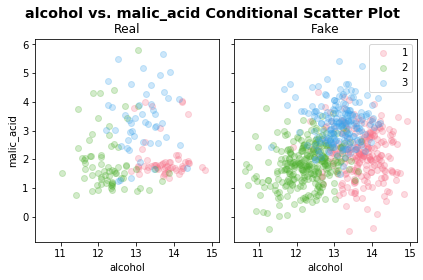

In [27]:
plot_conditional_scatter(col1='alcohol',
                         col2='malic_acid',
                         real_df=wine,
                         fake_df=genned_df,
                         dep_var=cfg.DEP_VAR,
                         cont_inputs=cfg.CONT_INPUTS,
                         labels_list=labels_list,
                         scaler=None,
                         alpha=0.25,
                         show=True,
                         save=exp_path)

/home/aj/PycharmProjects/CSDGAN/utils/utils.py:208: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


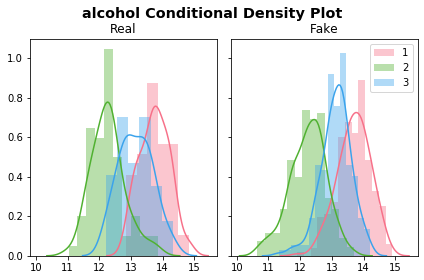

In [28]:
plot_conditional_density(col='alcohol',
                         real_df=wine,
                         fake_df=genned_df,
                         dep_var=cfg.DEP_VAR,
                         cont_inputs=cfg.CONT_INPUTS,
                         labels_list=labels_list,
                         scaler=None,
                         show=True,
                         save=exp_path)